In [5]:
import tensorflow as tf
import os

# Define the path to your dataset
DATA_PATH = '/kaggle/input/modified-next-day-wildfire-spread/ndws_western_dataset/'

# Find the first .tfrecord file in the directory
tfrecord_files = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith('.tfrecord')]
if not tfrecord_files:
    raise FileNotFoundError("No .tfrecord files found in the specified directory.")

# Get the first raw record from the file
raw_record = next(iter(tf.data.TFRecordDataset(tfrecord_files[0])))

# Parse it as a generic TensorFlow Example
example = tf.train.Example()
example.ParseFromString(raw_record.numpy())

# --- Detailed Inspection Loop ---
print("✅ Detailed Dataset Blueprint:")
print("-" * 60)
for name, feature in example.features.feature.items():
    # Check which type of list contains the data
    kind = feature.WhichOneof('kind')
    value_list = getattr(feature, kind).value
    
    # Determine the TensorFlow data type
    tf_type = "Unknown"
    if kind == 'float_list':
        tf_type = 'tf.float32'
    elif kind == 'int64_list':
        tf_type = 'tf.int64'
    elif kind == 'bytes_list':
        tf_type = 'tf.string'

    # Check the shape (is it a single value or an array?)
    shape_desc = f"Shape: [{len(value_list)}]" if len(value_list) > 1 else "Shape: Scalar (1 value)"
        
    print(f"- Feature: '{name}'")
    print(f"  - Stored as: {kind}")
    print(f"  - TF Type: {tf_type}")
    print(f"  - {shape_desc}")
print("-" * 60)
print("ACTION: Use this exact blueprint to build the final 'feature_description'.")

✅ Detailed Dataset Blueprint:
------------------------------------------------------------
- Feature: 'elevation'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'chili'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'impervious'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'water'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'population'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'fuel1'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'fuel2'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'fuel3'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'NDVI'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'pdsi'
  - Stored as: float_list
  - TF Type: tf.float32
  - Shape: [4096]
- Feature: 'pr'
  - Stored 

In [6]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import AUC
import os
import numpy as np
import pickle
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# --- 1. DATA PREPARATION ---
print("✅ 1. Setting up data pipeline with the definitive blueprint...")

# --- CORRECTED CONSTANTS ---
# The inspection revealed the image dimensions are 64x64.
DATA_PATH = '/kaggle/input/modified-next-day-wildfire-spread/ndws_western_dataset/'
IMG_HEIGHT = 64
IMG_WIDTH = 64
# The input shape is (Height, Width, 22 input features)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 22) 
BATCH_SIZE = 32

# All feature names found from the inspection step
ALL_FEATURE_NAMES = [
    'elevation', 'chili', 'impervious', 'water', 'population', 'fuel1', 
    'fuel2', 'fuel3', 'NDVI', 'pdsi', 'pr', 'erc', 'bi', 'avg_sph', 
    'tmp_day', 'tmp_75', 'gust_med', 'wind_avg', 'wind_75', 'wdir_wind', 
    'wdir_gust', 'viirs_PrevFireMask', 'viirs_FireMask'
]

# --- FINAL, CORRECTED FEATURE BLUEPRINT ---
# The inspection shows ALL features are float32 with a shape of 4096.
feature_description = {
    name: tf.io.FixedLenFeature([IMG_HEIGHT * IMG_WIDTH], tf.float32) 
    for name in ALL_FEATURE_NAMES
}

# Define the target and input feature names
TARGET_FEATURE = 'viirs_FireMask'
INPUT_FEATURES = [key for key in ALL_FEATURE_NAMES if key != TARGET_FEATURE]

def parse_tfrecord_fn(example):
    """Parses a single TFRecord example based on the definitive blueprint."""
    example = tf.io.parse_single_example(example, feature_description)
    
    image_bands = []
    for feature in INPUT_FEATURES:
        # Reshape the flattened array back into a 64x64x1 band
        band = tf.reshape(example[feature], (IMG_HEIGHT, IMG_WIDTH, 1))
        image_bands.append(band)
    image = tf.concat(image_bands, axis=-1)

    # Reshape the mask (it's already the correct float32 type)
    mask = tf.reshape(example[TARGET_FEATURE], (IMG_HEIGHT, IMG_WIDTH, 1))

    return image, mask

def create_dataset(tfrecord_files):
    """Creates a tf.data.Dataset pipeline."""
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# List all TFRecord files and create the full dataset
all_tfrecords = tf.data.Dataset.list_files(os.path.join(DATA_PATH, "*.tfrecord"), shuffle=False)
full_dataset = create_dataset(all_tfrecords)

# Split into training and validation sets
DATASET_SIZE = len(list(full_dataset))
train_size = int(0.8 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = full_dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Dataset created with {train_size} training samples and {DATASET_SIZE - train_size} validation samples.")


# --- 2. MODEL DEFINITIONS ---
# Models are updated to handle the new 64x64 input shape.
print("\n🧠 2. Defining model architectures...")

def build_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    u1 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c2)
    concat1 = layers.concatenate([u1, c1])
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(concat1)
    return Model(inputs, outputs)

def build_convlstm_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    reshaped = layers.Reshape((1, *input_shape))(inputs)
    conv_lstm = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=False)(reshaped)
    outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(conv_lstm)
    return Model(inputs, outputs)
    
def build_cnn_bilstm_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    cnn = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    cnn = layers.MaxPooling2D()(cnn) # Now 32x32
    h, w, c = cnn.shape[1:]
    reshaped = layers.Reshape((h * w, c))(cnn)
    lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(reshaped)
    reshaped_back = layers.Reshape((h, w, 128))(lstm)
    upsampled = layers.UpSampling2D(size=(2, 2))(reshaped_back) # Back to 64x64
    outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(upsampled)
    return Model(inputs, outputs)
    
def build_multiscale_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    b1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    b2 = layers.Conv2D(32, 7, activation="relu", padding="same")(inputs)
    concat = layers.concatenate([b1, b2])
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(concat)
    return Model(inputs, outputs)
    
models_to_train = {
    "UNET": build_unet_model,
    "ConvLSTM": build_convlstm_model,
    "CNN-BiLSTM": build_cnn_bilstm_model,
    "Multi-Scale CNN": build_multiscale_cnn_model,
}
results = {}

# --- 3. TRAINING AND EVALUATION LOOP ---
print("\n🔥 3. Starting training and evaluation loop...")
for name, builder in models_to_train.items():
    print(f"\n--- Training {name} ---")
    
    # Pass the corrected INPUT_SHAPE to the model builder
    model = builder(INPUT_SHAPE)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[AUC(curve='PR', name='average_precision')])
    
    model.fit(train_dataset, epochs=15, validation_data=validation_dataset, verbose=1) # Increased epochs slightly for better training
    
    print(f"--- Evaluating {name} ---")
    y_pred_probs = model.predict(validation_dataset)
    y_true_list = [y for x, y in validation_dataset]
    y_true = np.concatenate(y_true_list, axis=0)
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_probs.flatten()
    
    ap_score = average_precision_score(y_true_flat, y_pred_flat)
    print(f"⭐ {name} Average Precision (AP): {ap_score:.4f}")
    
    results[name] = {
        'ap': ap_score,
        'y_true': y_true_flat,
        'y_pred': y_pred_flat,
    }

print("\n✅ All models trained and evaluated.")

# Save final results to a file for plotting
with open('model_comparison_results.pkl', 'wb') as f:
    pickle.dump(results, f)

✅ 1. Setting up data pipeline with the definitive blueprint...
Dataset created with 16077 training samples and 4020 validation samples.

🧠 2. Defining model architectures...

🔥 3. Starting training and evaluation loop...

--- Training UNET ---
Epoch 1/15


I0000 00:00:1760171787.945707      93 service.cc:148] XLA service 0x78b86c0185e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760171787.946487      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760171788.235370      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


     11/Unknown 5s 17ms/step - average_precision: 0.0226 - loss: 16.8690

I0000 00:00:1760171790.133933      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    503/Unknown 13s 18ms/step - average_precision: 0.0320 - loss: 5.0753

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


503/503 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - average_precision: 0.0320 - loss: 5.0716 - val_average_precision: 0.0322 - val_loss: 4.1539
Epoch 2/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0349 - loss: 2.6450 - val_average_precision: 0.0322 - val_loss: 3.7023
Epoch 3/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0575 - loss: 1.9435 - val_average_precision: 0.0322 - val_loss: 6.3892
Epoch 4/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0434 - loss: 3.4138 - val_average_precision: 0.0499 - val_loss: 5.6051
Epoch 5/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0625 - loss: 1.8923 - val_average_precision: 0.1853 - val_loss: 0.4104
Epoch 6/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.1551 - loss: 0.4595 - val_average_precision: 0.0587 - val_loss: 2.0792
Epoch 7/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0986 - loss: 0.7249 - val_average_precision: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


503/503 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - average_precision: 0.0338 - loss: 0.1651 - val_average_precision: 0.0403 - val_loss: 0.1408
Epoch 2/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - average_precision: 0.0424 - loss: 0.1315 - val_average_precision: 0.0426 - val_loss: 0.1406
Epoch 3/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - average_precision: 0.0451 - loss: 0.1307 - val_average_precision: 0.0405 - val_loss: 0.1407
Epoch 4/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - average_precision: 0.0439 - loss: 0.1314 - val_average_precision: 0.0443 - val_loss: 0.1401
Epoch 5/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - average_precision: 0.0465 - loss: 0.1306 - val_average_precision: 0.0418 - val_loss: 0.1402
Epoch 6/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - average_precision: 0.0447 - loss: 0.1313 - val_average_precision: 0.0427 - val_loss: 0.1405
Epoch 7/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - average_precision: 0.0492 - loss: 0.1310 - val_average_precision: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


503/503 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - average_precision: 0.0375 - loss: 0.1532 - val_average_precision: 0.0428 - val_loss: 0.1404
Epoch 2/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - average_precision: 0.0462 - loss: 0.1306 - val_average_precision: 0.0422 - val_loss: 0.1404
Epoch 3/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - average_precision: 0.0516 - loss: 0.1299 - val_average_precision: 0.0581 - val_loss: 0.1381
Epoch 4/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - average_precision: 0.0559 - loss: 0.1288 - val_average_precision: 0.0652 - val_loss: 0.1380
Epoch 5/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - average_precision: 0.0608 - loss: 0.1283 - val_average_precision: 0.0623 - val_loss: 0.1373
Epoch 6/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - average_precision: 0.0658 - loss: 0.1268 - val_average_precision: 0.0726 - val_loss: 0.1340
Epoch 7/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 54s 106ms/step - average_precision: 0.0679 - loss: 0.1260 - val_average_preci

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


503/503 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - average_precision: 0.0323 - loss: 13.1590 - val_average_precision: 0.0384 - val_loss: 1.2059
Epoch 2/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0373 - loss: 3.1099 - val_average_precision: 0.0942 - val_loss: 0.8454
Epoch 3/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0685 - loss: 1.8750 - val_average_precision: 0.1345 - val_loss: 0.5460
Epoch 4/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0938 - loss: 1.2505 - val_average_precision: 0.0328 - val_loss: 1.8137
Epoch 5/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.0536 - loss: 2.9008 - val_average_precision: 0.1767 - val_loss: 0.4224
Epoch 6/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.1103 - loss: 1.6686 - val_average_precision: 0.0395 - val_loss: 1.0534
Epoch 7/15
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - average_precision: 0.1430 - loss: 0.5146 - val_average_precision: 

📊 Loading model performance results...
✅ Results loaded successfully.


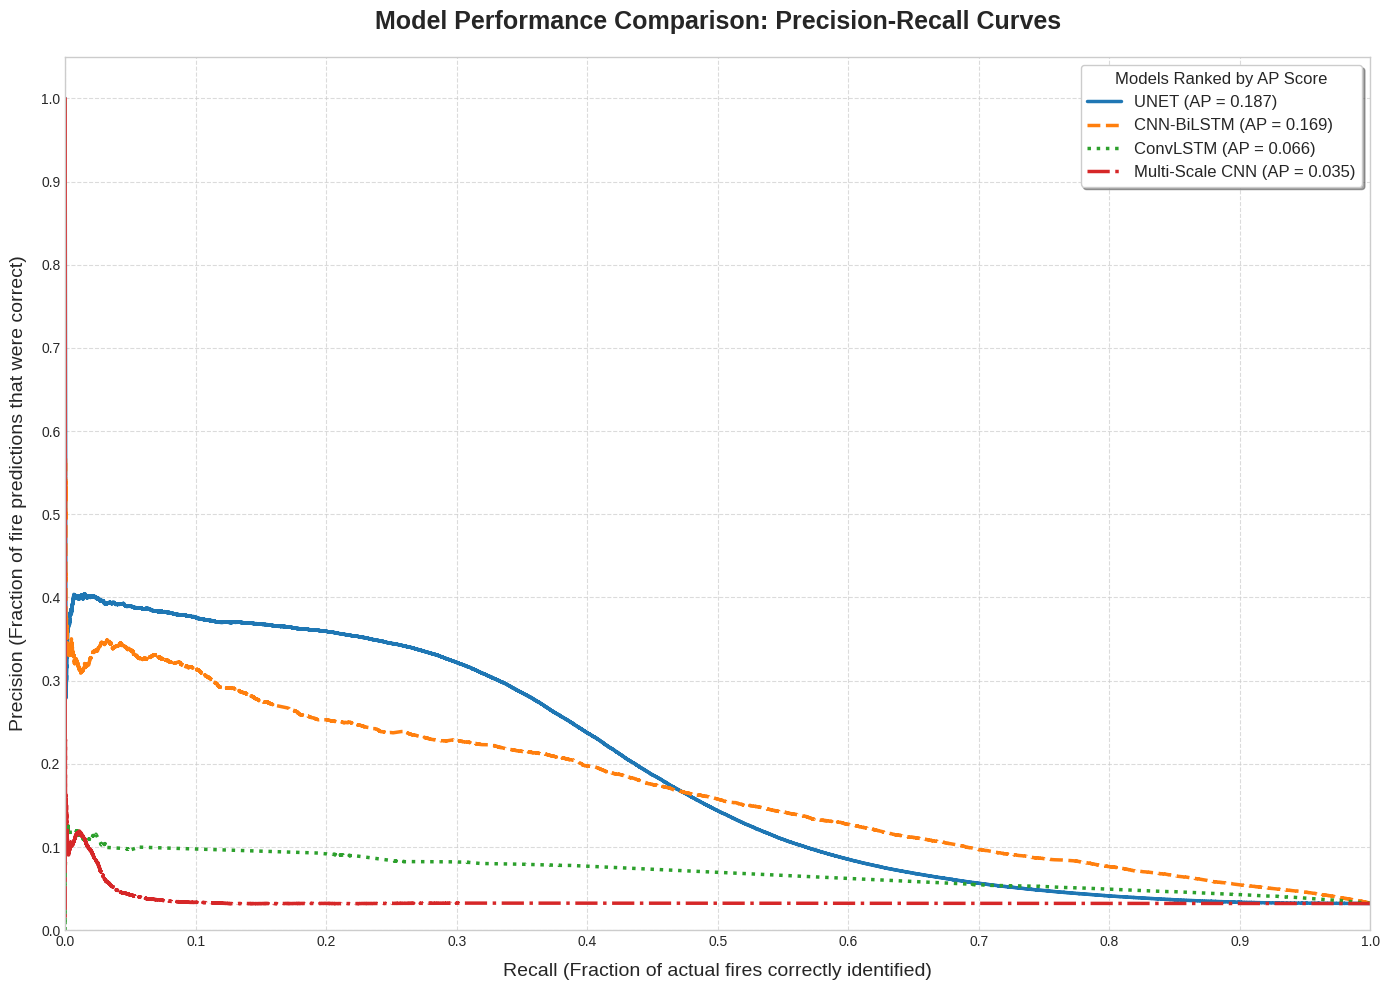

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
import pickle
import os

# --- 1. Load the Saved Results ---
RESULTS_FILE = 'model_comparison_results.pkl'

print("📊 Loading model performance results...")

if not os.path.exists(RESULTS_FILE):
    raise FileNotFoundError(
        f"The results file '{RESULTS_FILE}' was not found. "
        "Please ensure the training script has been run successfully first."
    )

with open(RESULTS_FILE, 'rb') as f:
    results = pickle.load(f)

print("✅ Results loaded successfully.")

# --- 2. Generate the Enhanced Precision-Recall Curve Plot ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))

# Sort the models by their AP score for a clean legend
sorted_models = sorted(results.items(), key=lambda item: item[1]['ap'], reverse=True)

# Define distinct line styles and colors
line_styles = ['-', '--', ':', '-.']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Loop through each model's results to plot its curve
for i, (name, data) in enumerate(sorted_models):
    precision, recall, _ = precision_recall_curve(data['y_true'], data['y_pred'])
    ap_score = data['ap']
    
    plt.plot(recall, precision, 
             lw=2.5,
             linestyle=line_styles[i % len(line_styles)],
             color=colors[i % len(colors)],
             label=f'{name} (AP = {ap_score:.3f})')

# Add titles and labels with increased font sizes for clarity
plt.title('Model Performance Comparison: Precision-Recall Curves', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Recall (Fraction of actual fires correctly identified)', 
           fontsize=14, labelpad=10)
plt.ylabel('Precision (Fraction of fire predictions that were correct)', 
           fontsize=14, labelpad=10)

# Set axis limits and ticks
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)

# Position the legend in the best spot to avoid overlap
plt.legend(loc='upper right', 
           fontsize=12, 
           title="Models Ranked by AP Score", 
           title_fontsize=12,
           frameon=True,
           shadow=True,
           fancybox=True)

# Use lighter grid lines for a cleaner background
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the final, professional plot
plt.show()

In [11]:
# First, ensure ydata-profiling is installed in your environment
!pip install -q ydata-profiling pandas

import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np

print("📊 Preparing a sample of the dataset for profiling...")

# This is the list of your 22 input features plus the target mask
ALL_FEATURES = [
    'elevation', 'chili', 'impervious', 'water', 'population', 'fuel1', 
    'fuel2', 'fuel3', 'NDVI', 'pdsi', 'pr', 'erc', 'bi', 'avg_sph', 
    'tmp_day', 'tmp_75', 'gust_med', 'wind_avg', 'wind_75', 'wdir_wind', 
    'wdir_gust', 'viirs_PrevFireMask', 'viirs_FireMask'
]

# Create a dictionary to hold the flattened pixel data for each feature
feature_pixel_data = {name: [] for name in ALL_FEATURES}

# --- 1. Extract and Flatten Data from a Sample of Batches ---
# We'll take a sample from the validation set for a quick but informative analysis.
# Increase the number in .take() for a more detailed report (will take longer).
num_batches_to_profile = 25 

for images, masks in validation_dataset.take(num_batches_to_profile):
    # Combine the input images and the masks back into one tensor for easy processing
    # The mask becomes the 23rd channel
    full_data_tensor = np.concatenate([images.numpy(), masks.numpy()], axis=-1)
    
    # For each feature channel (0 to 22), flatten the pixel data and append it
    for i, feature_name in enumerate(ALL_FEATURES):
        # Get the current feature channel across all images in the batch
        # Shape: (batch_size, 64, 64)
        feature_channel = full_data_tensor[:, :, :, i]
        
        # Flatten the spatial dimensions (64x64 -> 4096) for each image
        # and add all these pixel values to our dictionary
        feature_pixel_data[feature_name].extend(feature_channel.flatten())

print(f"✅ Data extracted from {num_batches_to_profile} batches.")

# --- 2. Create a Pandas DataFrame ---
print("Creating pandas DataFrame from pixel data...")
df_pixels = pd.DataFrame(feature_pixel_data)

print("DataFrame created with the following shape:", df_pixels.shape)
print("\nDataFrame Head:")
print(df_pixels.head())


# --- 3. Generate the Interactive Profile Report ---
print("\n🚀 Generating profile report... (This may take a few minutes)")
# Generate the report. Using minimal=True for a faster, more focused report.
profile = ProfileReport(df_pixels, 
                        title="Exploratory Data Analysis of Wildfire Features", 
                        minimal=True) # Use minimal=True for speed

# Display the report directly in your Kaggle notebook
profile

📊 Preparing a sample of the dataset for profiling...
✅ Data extracted from 25 batches.
Creating pandas DataFrame from pixel data...
DataFrame created with the following shape: (3276800, 23)

DataFrame Head:
   elevation  chili  impervious  water  population     fuel1     fuel2  \
0     2287.0  172.0         0.0    0.0         0.0 -0.883272  2.170912   
1     2278.0  194.0         0.0    0.0         0.0  0.058215  1.069080   
2     2230.0  199.0         0.0    0.0         0.0 -0.142410  0.680636   
3     2239.0  138.0         0.0   39.0         0.0 -0.700478  1.083290   
4     2226.0  214.0         0.0    0.0         0.0 -0.700478  1.083290   

      fuel3    NDVI      pdsi  ...   avg_sph    tmp_day     tmp_75  gust_med  \
0 -1.710343  2816.0 -5.529089  ...  0.003268  20.842297  21.081459  3.006636   
1  0.901074  2681.0 -5.552496  ...  0.003285  21.140341  21.394922  2.961281   
2  0.521478  2220.0 -5.576569  ...  0.003306  21.465725  21.737219  2.912065   
3  1.002642  3194.0 -5.60102

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:23<00:00,  1.02s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]